### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot variables distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [49]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from hist.intervals import ratio_uncertainty
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector

### Read SlimmedTree files

In [3]:
# load the slimmedtree files using uproot

# different year available here.
#year = "2016"
year = "2017"
# year = "2018"
#year = "Full-Run2"

# if run on PKU cluster, use this:
CustNanoData = {
    'data'        : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/Data/SlimmedTree_Data.root"   % (year),
    'QCD'         : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_QCD.root"   % (year),
    'TT'          : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_TT.root"     % (year),
    'ST'          : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_ST.root"     % (year),
    'WJets'       : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_WJets.root" % (year),
    'Rest'        : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_Rest.root"  % (year),
    'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/Wcb_V1/%s/MC/SlimmedTree_WJets.root" % (year),
}

files = { }
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"})

In [4]:
MAIN_DIR = "."

plot_dir = f"{MAIN_DIR}/plots/23May2014"
_ = os.system(f"mkdir -p {plot_dir}")

In [5]:
for typefile in files:
    print('%-16s' % typefile, '%10d' % len(files[typefile]), sep='\t')

data            	  41845929
QCD             	  31399695
TT              	   6682512
ST              	    624027
WJets           	   7098909
Rest            	   4016334
TotalSignal     	   7098909


### Select events

In [6]:
files_orglen = {k: len(files[k]) for k in files}
for k in files:
    if k == "TotalSignal":
        files[k] = files[k][files[k]["isWcb"] == 1]
    else:
        files[k] = files[k][files[k]["isWcb"] == 0]

ValueError: key "isWcb" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/util.cpp#L525)

### Define taggers

In [11]:
def add_tagger(events):
    events["probQCD"] = ak.zeros_like(events["a_Hbc"])
    qcd_list = [
    "a_QCDbb",
    "a_QCDcc",
    "a_QCDb",
    "a_QCDc",
    "a_QCDothers",
    ]
    for score in qcd_list:
        events["probQCD"] = events["probQCD"] + events[score]
    events["HbcVSQCS"] = (events["a_Hbc"])/(events["a_Hbc"] + 0.997032*events["probQCD"] + 0.002968*events["a_Hcs"])
for k in files:
    print("Add tagger of:",k)
    add_tagger(events=files[k])

Add tagger of: data
Add tagger of: QCD
Add tagger of: TT
Add tagger of: ST
Add tagger of: WJets
Add tagger of: Rest
Add tagger of: TotalSignal
Add tagger of: W
Add tagger of: g/q
Add tagger of: rest


In [ ]:
for typefile in files:
    print('%-16s' % typefile, '%10d' % len(files[typefile]), '%10d' % (len(files[typefile]) - files_orglen[typefile]), sep='\t')

QCD             	  70185258	         0
Top             	  20233428	      -915
WJets           	  11094576	     -9734
Rest            	   2869121	         0
TotalSignal     	      9734	 -11094576


In [ ]:
print(len(Top_isWcb))

915


In [12]:
files["W"] = files["TotalSignal"][files["TotalSignal"]["w_a"] == 1]
files["g/q"] = files["TotalSignal"][files["TotalSignal"]["gKK_g_a"] == 1]
files["rest"] = files["TotalSignal"][(files["TotalSignal"]["gKK_g_a"] != 1) & (files["TotalSignal"]["w_a"] != 1)]

In [8]:
print(len(files["W"]))
print(len(files["g/q"]))
print(len(files["rest"]))

3153109
3655742
290058


### output all the variables for which we can make plots

In [ ]:
files["TotalSignal"].fields

['genH_pt',
 'matchingt_a',
 'matchingW_a',
 'matchingg_a',
 'matchingZ_a',
 'matchingu_a',
 'matchingd_a',
 'matchings_a',
 'matchingc_a',
 'matchingg_first_a',
 'matchingu_first_a',
 'matchingd_first_a',
 'matchings_first_a',
 'matchingc_first_a',
 'matchingqg_first_a',
 'matchingt_first_a',
 'matchingt_b',
 'matchingW_b',
 'matchingg_b',
 'matchingZ_b',
 'matchingu_b',
 'matchingd_b',
 'matchings_b',
 'matchingc_b',
 'matchingg_first_b',
 'matchingu_first_b',
 'matchingd_first_b',
 'matchings_first_b',
 'matchingc_first_b',
 'matchingqg_first_b',
 'matchingt_first_b',
 'matchingt_c',
 'matchingW_c',
 'matchingg_c',
 'matchingZ_c',
 'matchingu_c',
 'matchingd_c',
 'matchings_c',
 'matchingc_c',
 'matchingg_first_c',
 'matchingu_first_c',
 'matchingd_first_c',
 'matchings_first_c',
 'matchingc_first_c',
 'matchingqg_first_c',
 'matchingt_first_c',
 'R4q_a',
 'R4q_b',
 'R4q_c',
 'R3q_a',
 'R3q_b',
 'R3q_c',
 'R2q_a',
 'R2q_b',
 'R2q_c',
 'w_a',
 'w_b',
 'w_c',
 't_a',
 't_b',
 't_c',
 

### plot setting, error setting, histogram setting

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### define main plots function

In [52]:
from matplotlib.cm import get_cmap
hep.style.use("CMS")
def makeplots(arrays, weight, plot_name: str, x_name: str, region = 'PS',othertext = "", year='2018', nbins=20, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False,log = False,blind = True, blindMC = False, nametext = "",optimal_cut = True, deco = False,postfit_files = ""):
    LUMI = {"2016APV": 19.52, "2016": 16.81, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    bin_width = (x_max-x_min)/nbins
    #blind data in this region
    if blind:
        mask = np.logical_or(arrays["data"] <= 50, arrays["data"] >= 110)
        arrays["data"] = arrays["data"][mask]
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    # Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()    
    # analyze
    stacked = {'h': {}, 'var': {}} 
    individual = {'h': {}, 'var': {}}
    BKG = ["QCD","TT","ST","WJets","Rest"]
    name_dict_sig = {
        #sig
        "TotalSignal":"TotalSig",
        "ggF"        :'ggF',
        "ttH"        :"ttH",
        "VBF"        :"VBF",
        "WH"         :"WH",
        "ZH"         :"ZH",
    }
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var        
    #plot
    SIG_COLOR={'TotalSignal': 'black'}
    SIG_DECO_COLOR = {'TotalSignal': 'black',"W":"blue","g/q":"pink","rest":"gray"}
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    if len(stacked['h'].keys())>0:
        BKG_list = ["Rest","WJets","TT","ST","QCD"]
        err_list = [  np.nan_to_num(error_bar(stacked['h'][k], stacked['var'][k], type = "mc"), nan = 0) for k in BKG_list]
        h_list = [stacked['h'][k] for k in BKG_list]
        label_list = BKG_list
        # colors = ["#1f77b4", "#ff7f0e", "#2ca02c","green","#d62728"] #old color regime
        colors = ["#5790fc", "#f89c20", "#e42536", "#964a8b", "#9c9ca1"] #latest color regime according to:https://cms-analysis.docs.cern.ch/guidelines/plotting/colors/#1d-histogramstackplot
        # corresponds to Rest, WJets, TT, ST, QCD
        # colors = colors[::-1]
        hep.histplot(h_list, bins=hist.axes[0].edges, label=label_list,  histtype='fill', density=density, stack=True, linewidth=2, ax=ax,color = colors)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        print(bkg_h)
        bkg_err = np.sum(err_list ,  axis=0)
        print(bkg_err)
        bin_edges = np.linspace(x_min, x_max, nbins+1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #plot grey bar for systematic uncertainties
        # ax.errorbar(x = bin_centers,y = bkg_h, yerr=bkg_err, fmt='none', color='gray', capsize=2,markersize = 3)
        
        #add dashed region for systematic uncertainties
        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
            "label":"Stat. Unc.",
        }
        ax.stairs(values = bkg_h + bkg_err[0], baseline = bkg_h - bkg_err[1], edges = hist.axes[0].edges, **errps)
        
    # Scale the signal according to total BKG to make it visiable:
    NORM_s1=np.sum(bkg_h)/(np.sum(individual["h"]["TotalSignal"])+0.000001)
    print("Should scale signal * ",NORM_s1)
    if                       NORM_s1>=300000: NORM_s1=300000
    elif  300000>NORM_s1 and NORM_s1>=100000: NORM_s1= 100000
    elif  100000>NORM_s1 and NORM_s1>= 30000: NORM_s1= 30000
    elif   30000>NORM_s1 and NORM_s1>= 10000: NORM_s1=  10000
    elif   10000>NORM_s1 and NORM_s1>=  3000: NORM_s1=  3000
    elif    3000>NORM_s1 and NORM_s1>=  1000: NORM_s1=   1000
    elif    1000>NORM_s1 and NORM_s1>=   300: NORM_s1=   300
    elif     300>NORM_s1 and NORM_s1>=   100: NORM_s1=    100
    elif     100>NORM_s1 and NORM_s1>=    30: NORM_s1=    30
    elif      30>NORM_s1 and NORM_s1>=    10: NORM_s1=     10
    else                                    : NORM_s1=     1   
    for (k,h) in individual['h'].items():
        if k=='data': #data
            err = error_bar(h, individual['var'][k], type='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=False, stack=False, ax=ax)
            
            data_mc_ratio = np.sum(h)/np.sum(bkg_h)
            print(data_mc_ratio)
            
            ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
            print(ratio_error)
            
            # now first directly scale the data error with `data/MC` ratio
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)    
            
            
            # then add shaded error to ratio plot
            errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 1,
            "alpha": 0.4,
            "label":"Stat. Unc."
            }
            
            ax1.stairs(values = 1 + bkg_err[0]/bkg_h, baseline = 1 - bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
        
        else:  # signal
            if deco != True: #plot signal in different production mode
                if k in ["TotalSignal"]:
                    err = error_bar(h, individual['var'][k], type='mc')
                    hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_COLOR[k])
            
            else: #plot signal in signal decomposition mode
                if k not in ["ggF","VH","ttH","VBF"]:
                    frac = "(" + "%.1f"%(np.sum(h)/np.sum(individual['h']["TotalSignal"])*100)+ "%)"
                    err = error_bar(h, individual['var'][k], type='mc')
                    if k != "TotalSignal": hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+frac, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    else:hep.histplot(h*NORM_s1, bins=hist.axes[0].edges, yerr=NORM_s1*err, label=k+r"$\times$"+str(NORM_s1), histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_DECO_COLOR[k])
                    y = h / np.sqrt(bkg_h + 1)
                    hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=False, stack=False, ax=ax2, color=SIG_DECO_COLOR[k])
            
            if k == "TotalSignal": #print optimal cut information
                best_lower, best_upper, best_s_sqrt_b = optimalcut(h,bkg_h)
                print("Optimal two-side cut =",best_lower, best_upper, best_s_sqrt_b)
                best_cut, best_s_sqrt_b = optimalcut_oneside(h,bkg_h)
                print("Optimal one-side cut =",best_cut, best_s_sqrt_b) 
                # best_cut, best_combined_sig_two_side = optimalcut_mid_combine(individual['h'][r"$H^{4q}$"],individual['h'][r"$H^{lqq}$"],bkg_h)
                # print("Optimal mid-side cut = ",best_cut,best_combined_sig_two_side)
            if optimal_cut == True:
                cut_value_low = x_min + best_lower * (x_max - x_min)/nbins
                ax2.axvline(x=cut_value_low, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_low, ax2.get_ylim()[1]), xytext=(cut_value_low - (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                cut_value_up = x_min + best_upper * (x_max - x_min)/nbins
                ax2.axvline(x=cut_value_up, color='r', linestyle='-')
                ax2.annotate('', xy=(cut_value_up, ax2.get_ylim()[1]), xytext=(cut_value_up + (x_max - x_min)/20 , ax2.get_ylim()[1]),arrowprops=dict(facecolor='red', arrowstyle="->"))                
                if cut_value_low < (x_max - cut_value_up):
                    text_position = cut_value_up + (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='left',fontsize = 13)
                else: 
                    text_position = cut_value_low - (x_max - x_min)/20
                    ax2.text(text_position, ax2.get_ylim()[1], r'$S/\sqrt{B+1}$'+"=%s"%(str(round(best_s_sqrt_b,3))), verticalalignment='center', horizontalalignment='right',fontsize = 13)

    ax.set_xlim(x_min, x_max)
    if log:
        ax.set_yscale('log')
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*1e1)
    else:
        ax.set_ylim(0.01 if not density else 0, ax.get_ylim()[1]*1.3)
    # if not density:
    #     ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        # ax1.set_ylim(0, 2)
        ax1.set_ylim(0.3, 1.8)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.4)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)
    plt.xticks(size=14)
    plt.yticks(size=14)
    if blind:
        plt.text(0.05,0.83,region ,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.76,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)
    else:
        plt.text(0.05,0.83,region,fontsize=17, color="black", ha='left',transform=ax.transAxes)
        plt.text(0.05,0.73,othertext,fontsize=17, color="black", ha='left',transform=ax.transAxes)        
    ax.legend(loc="upper right", ncol=2, frameon=False, fontsize=12)
    suffix = '_AU' if density else ''
    if deco: suffix += "_DECO"
    path_str = plot_dir
    if not os.path.exists(path_str):
        os.makedirs(path_str)
    othertext = othertext.replace(",","")
    othertext = othertext.replace(" ","")
    othertext = othertext.replace("(","")
    othertext = othertext.replace(")","")
    othertext = othertext.replace("=","")
    plt.savefig(f"{path_str}/{year}_{plot_name}{suffix}_{region}{othertext}{nametext}.pdf", bbox_inches='tight')
    plt.show()

### define the cut for each regions, for examples, SRs, CRs, PS and MET regions here:

In [13]:
CUT = {        
    "SR1" : {k:  (files[k]["nb_t_deep_in"] == 0) & (files[k]["HbcVSQCS"] >= 0.998) for k in files}, 
    "SR2" : {k:  (files[k]["nb_t_deep_in"] == 0) & (files[k]["HbcVSQCS"] >= 0.980) & (files[k]["HbcVSQCS"] <= 0.998) for k in files}, 
    "SR3" : {k:  (files[k]["nb_t_deep_in"] == 0) & (files[k]["HbcVSQCS"] >= 0.9) & (files[k]["HbcVSQCS"] <= 0.980) for k in files}, 
    "CR"  : {k:  (files[k]["nb_t_deep_in"] == 0) & (files[k]["HbcVSQCS"] < 0.9)  for k in files},   
    "PS"  : {k:  (files[k]["nb_t_deep_in"] >= 0)  for k in files}, 
  
    }

# CR: tagger < 0.92

### define the variables we want to plot

In [53]:
def run_makeplots(region = "PS", events = files, nametext = "", blind = False, othertext = "", deco = False, optimal_cut = True):
    weight={k: events[k][CUT[region][k]]["weight"] for k in events}  # weight for each event
    makeplots(arrays = {k: events[k][CUT[region][k]]["Mj_corr_V2_a"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='jetmass', x_name=r'$jet_{a}$:soft-drop jet mass', x_max=230, x_min=30, nbins=20, weight =weight, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut)
    makeplots(arrays = {k: events[k][CUT[region][k]]["HbcVSQCS"] for k in events},  region = region, nametext = nametext, othertext = othertext,plot_name='Hbctagger', x_name=r'HbcVSQCS tagger:$jet_{a}$', x_max=1, x_min=0, nbins=40, weight =weight, year="2017",blind = blind, deco = deco,optimal_cut = optimal_cut, log = True)
    # add the variables you want to plot here, like above.

### make plots for each region, some examples are shown here

[4580561.34872288 6629152.99624577 6581023.90066303 6495356.63141604
 6466627.76959275 6380195.81945785 6136611.8989982  5668367.09240289
 5098094.8253581  4482548.24533003 3858705.40491804 3233252.06536943
 2658736.85067262 2138375.57838549 1699196.12806045 1324834.13894037
 1014838.05324     766148.18429459  574228.96277674  428722.37910559]
[[5835.30388613 7143.21596297 7203.2468278  7333.6691829  7468.34162835
  7502.58883767 7360.74553222 6991.72289466 6505.70851134 6013.73769382
  5467.77824002 4884.48911461 4314.72850331 3783.58680195 3276.65261917
  2817.31486375 2371.94640206 1971.84258891 1623.32838848 1320.53963508]
 [5835.30388613 7143.21596297 7203.2468278  7333.6691829  7468.34162835
  7502.58883767 7360.74553222 6991.72289466 6505.70851134 6013.73769382
  5467.77824002 4884.48911461 4314.72850331 3783.58680195 3276.65261917
  2817.31486375 2371.94640206 1971.84258891 1623.32838848 1320.53963508]]
Should scale signal *  126.95657742962011
0.5370273233758184
[[0.00141358 0

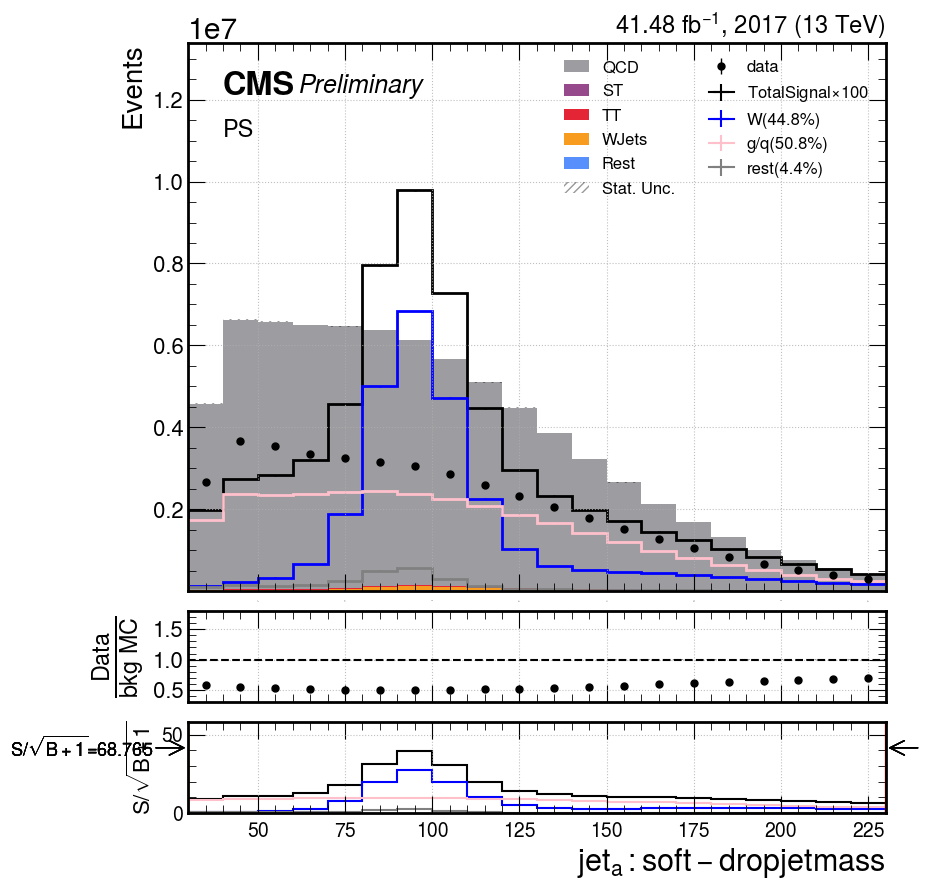

[58991508.05833954  4938426.14749504  2430487.11186455  1550015.06805608
  1118905.17171934   860942.08167313   696242.19355891   579507.27813786
   498830.39373293   434511.87563456   383571.32429881   348953.07574849
   317885.79062323   285311.66026862   265007.90426436   246829.95351048
   229378.90580591   216205.19743116   203514.13544213   191366.6501536
   180351.02985373   174273.60114975   166315.25988538   156416.1165826
   153419.77927256   147786.29576508   139988.92127157   135462.91911219
   132541.32409812   128482.28252554   125544.0934918    123594.50630028
   121494.7759535    119296.8204185    118324.32637819   116436.75687338
   118121.36287129   117694.22319628   120111.10897028   109010.49775741]
[[21488.7776718   6184.16396784  4341.2571377   3472.41874142
   2954.4245922   2573.86535687  2307.18074617  2103.80721446
   1957.11618305  1825.13928497  1725.97793968  1642.32738821
   1573.87052566  1476.84226138  1434.49355488  1377.62277798
   1337.09697354  1285.

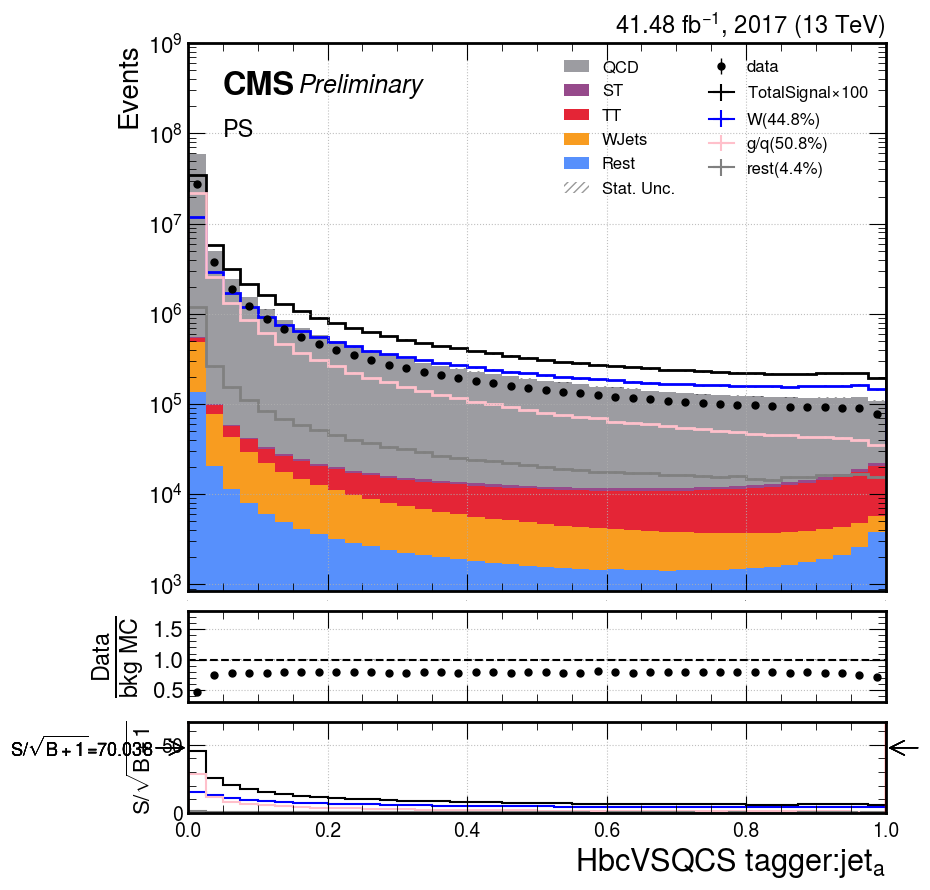

/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))


[ 86.34358493 119.50463304  54.43873012 141.77041011 109.96386308
 104.25191302  58.08134889  76.25587772  51.93322112  31.03668552
  44.51957143   9.4689034   36.78599152  12.78785646  11.96220754
   8.86768473   4.84796467   2.70677531   3.2317902   11.47221041]
[[22.16098027 29.06645983 15.02576107 30.73661995 28.53322753 42.28025175
  11.07914396 19.34659805 17.16916747 11.6251475  16.82223804  3.74764265
  16.52088255  7.70356976  4.15210971  3.25351453  1.24544462  0.59156012
   1.98087463  7.85618143]
 [22.53368935 29.15014895 15.26028693 32.34442944 28.91520819 76.37300925
  15.35497115 26.53690936 24.96667436 17.92401224 25.43506078  6.03323772
  26.93246361 17.73291499  6.64497816  6.01250307  2.09164491  0.87865659
   4.31175452 17.32569076]]
Should scale signal *  20.729639533177263
0.37236112393859594
[[0.27724282 0.26580525        nan        nan        nan        nan
         nan        nan 0.36483757 0.41806588 0.43157581 0.46418605
  0.51400193 0.65903708 0.4597707  0.4

/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered i

Optimal two-side cut = 5 7 2.1146225397653025
Optimal one-side cut = 4 1.7121829955105239


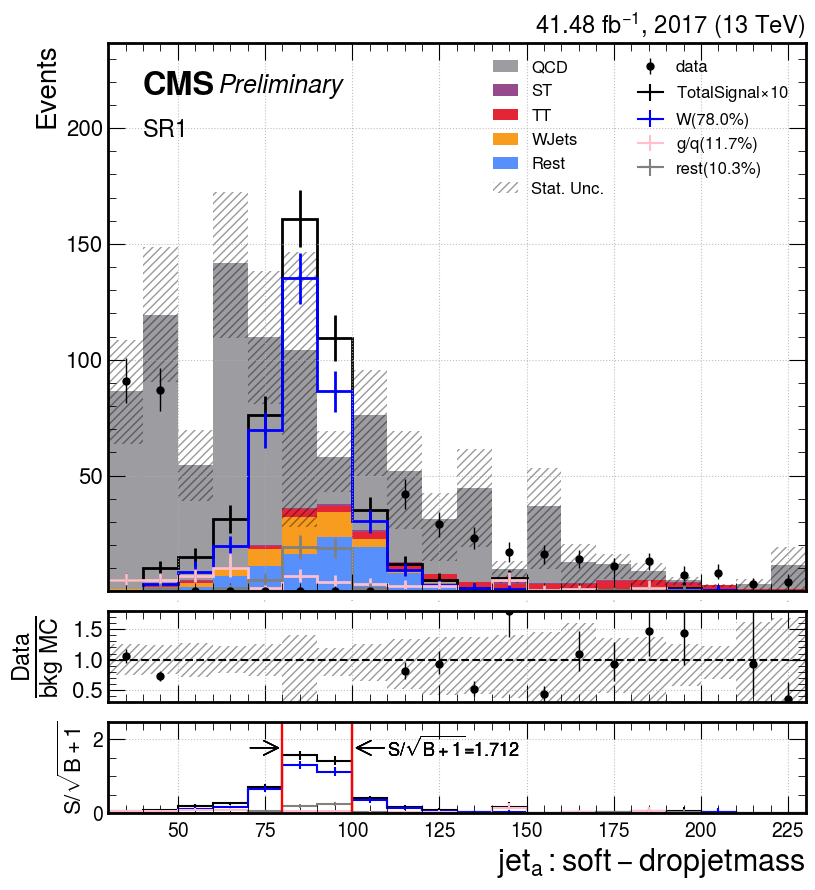

/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_703260/1466309391.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_703260/1466309391.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 + bkg_err[0]/bkg_h, baseline = 1 - bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_703260/314

[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.         1000.11809807]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         86.46761132]
 [ 0.          0.          0.          0

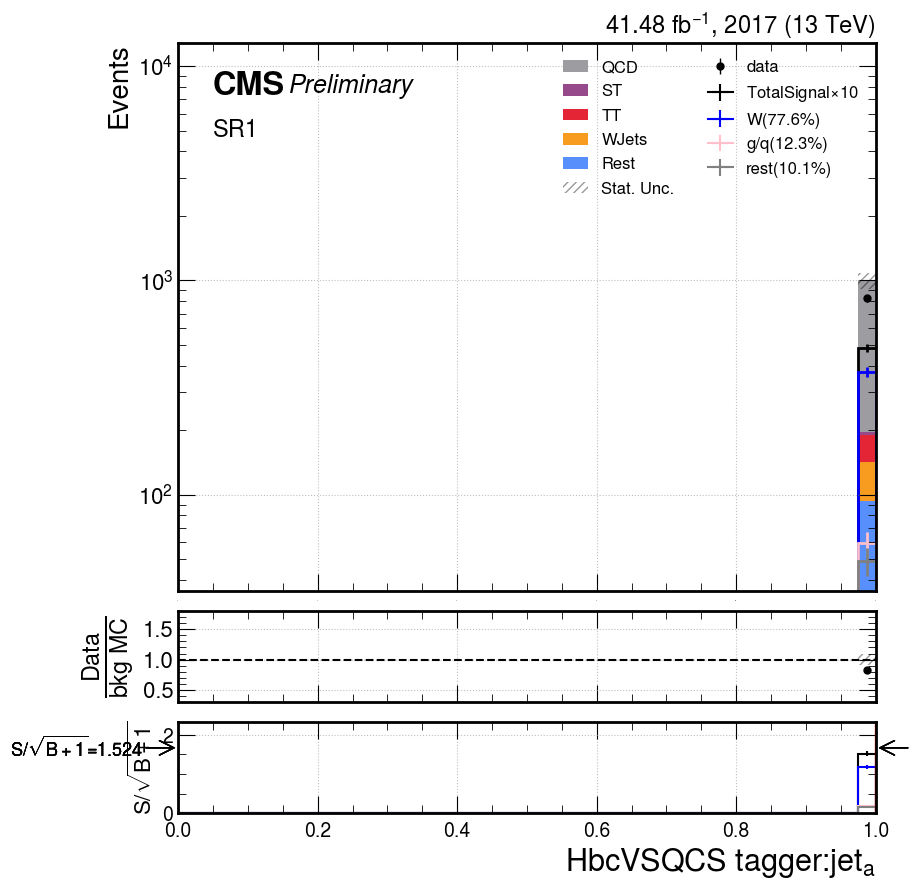

[1725.09952336 2357.26960869 1924.89655284 2112.21231707 2045.09541562
 1991.36601944 1873.75596217 1418.12729193 1084.77924593  954.72615717
  844.90526821  610.71549722  522.56471782  502.61131134  355.56356233
  291.94581697  218.41404688  213.92805706  115.94426635   96.33584717]
[[123.01988257 139.02808001 111.12940916 120.65793738 121.66418153
  120.48228589 109.53345442  87.90155751  86.6247543   94.77801933
   84.33291743  72.16815641  56.68887442  57.34946361  41.15760199
   35.24724765  27.13520499  30.83707184  21.608417    16.79777756]
 [123.20044381 139.02808001 111.12940916 120.65793738 121.66418153
  120.48228589 109.53345442  87.90155751  86.6247543   94.77801933
   84.33291743  72.16815641  56.68887442  57.34946361  41.15760199
   35.24724765  27.13520499  30.83707184  21.608417    17.07346361]]
Should scale signal *  23.52872380383054
0.3735608742720213
[[0.07667065 0.06405518        nan        nan        nan        nan
         nan        nan 0.08637246 0.10566758 0.

/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h


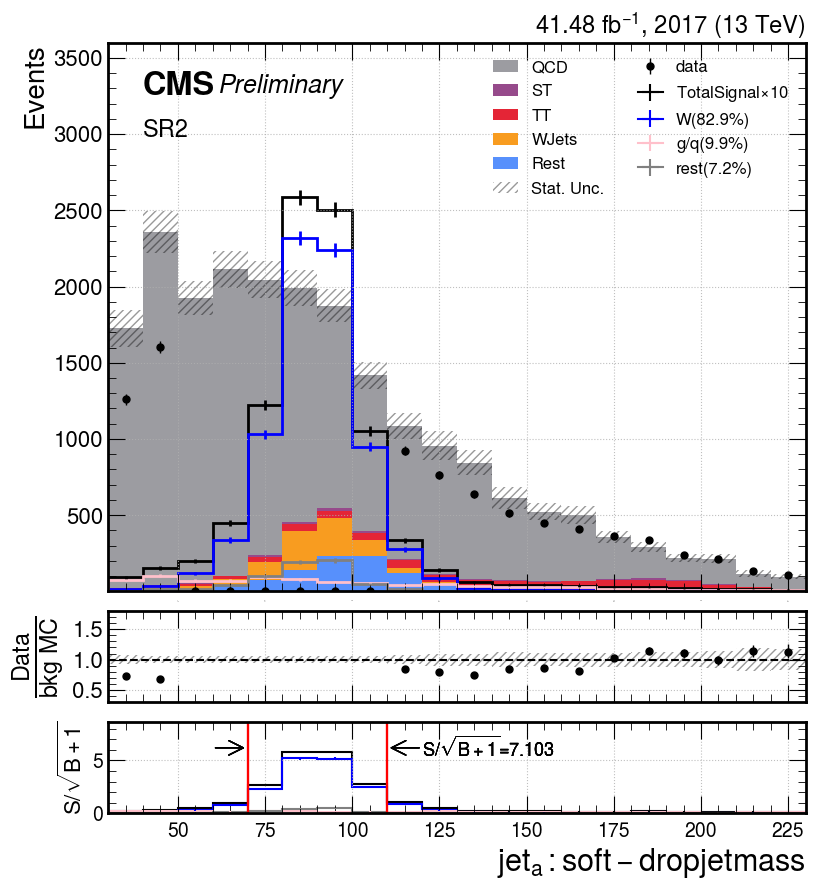

/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_703260/1466309391.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_703260/1466309391.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 + bkg_err[0]/bkg_h, baseline = 1 - bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_703260/314

[    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.         21569.51244525]
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.   

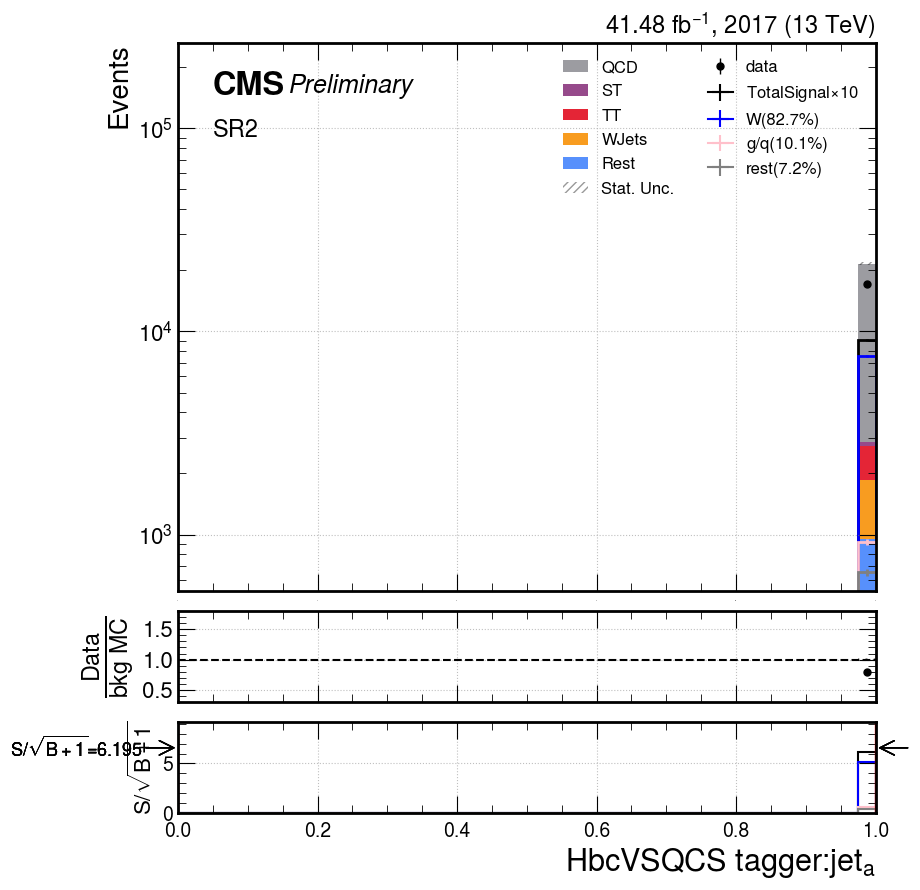

[ 7657.47743183 10978.08362735 11458.04476474 11394.83436548
 11727.19010858 12453.31978163 11119.66897562  9009.28213473
  7454.00416681  5732.9834656   4849.48444248  4216.38990113
  3606.31705313  2649.23315733  2503.22335863  2078.44225707
  1617.91430878  1256.39994532   848.98557877   642.34196538]
[[233.50034208 297.65581661 321.3878235  321.80856736 320.65162769
  341.76353302 289.04545301 266.82979464 233.03764977 207.08037815
  173.4151843  170.12774794 157.46088642 117.60448551 112.84347082
  102.53758742  92.79520666  75.3519137   54.22197705  48.73166134]
 [233.50034208 297.65581661 321.3878235  321.80856736 320.65162769
  341.76353302 289.04545301 266.82979464 233.03764977 207.08037815
  173.4151843  170.12774794 157.46088642 117.60448551 112.84347082
  102.53758742  92.79520666  75.3519137   54.22197705  48.73166134]]
Should scale signal *  24.5938526937335
0.41171204281536133
[[0.03291888 0.02900626        nan        nan        nan        nan
         nan        nan 0.0

/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))


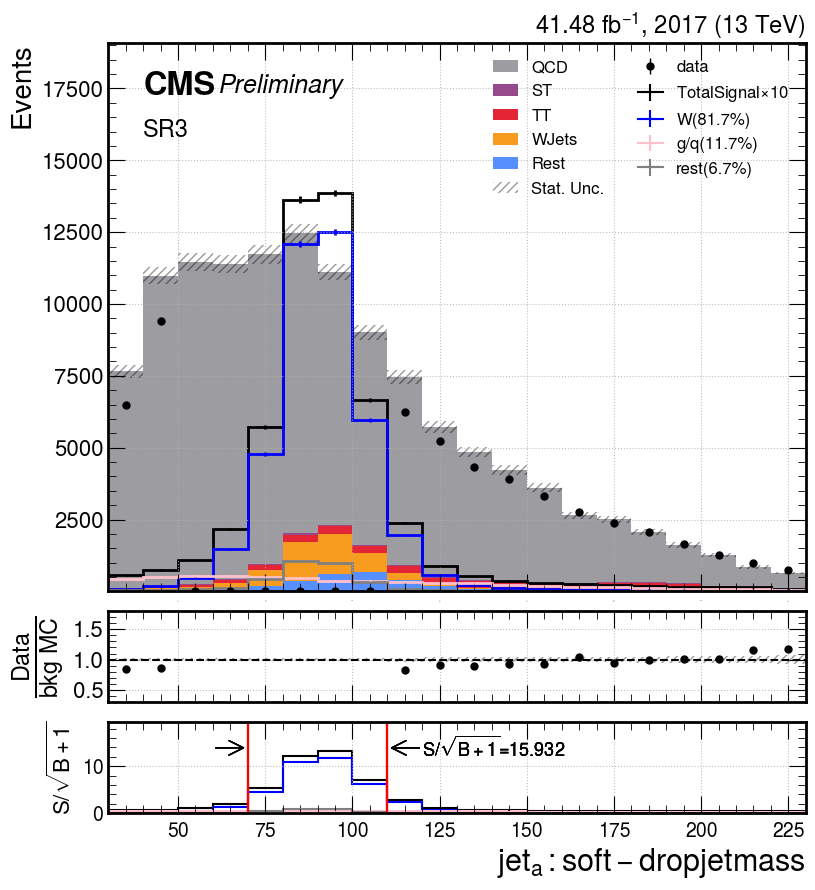

/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_703260/1466309391.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_703260/1466309391.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 + bkg_err[0]/bkg_h, baseline = 1 - bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_703260/314

[    0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
 41534.41850255 38999.29668828 37512.06643217  7185.90316592]
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.         561.75766741 559.5931885  541.800

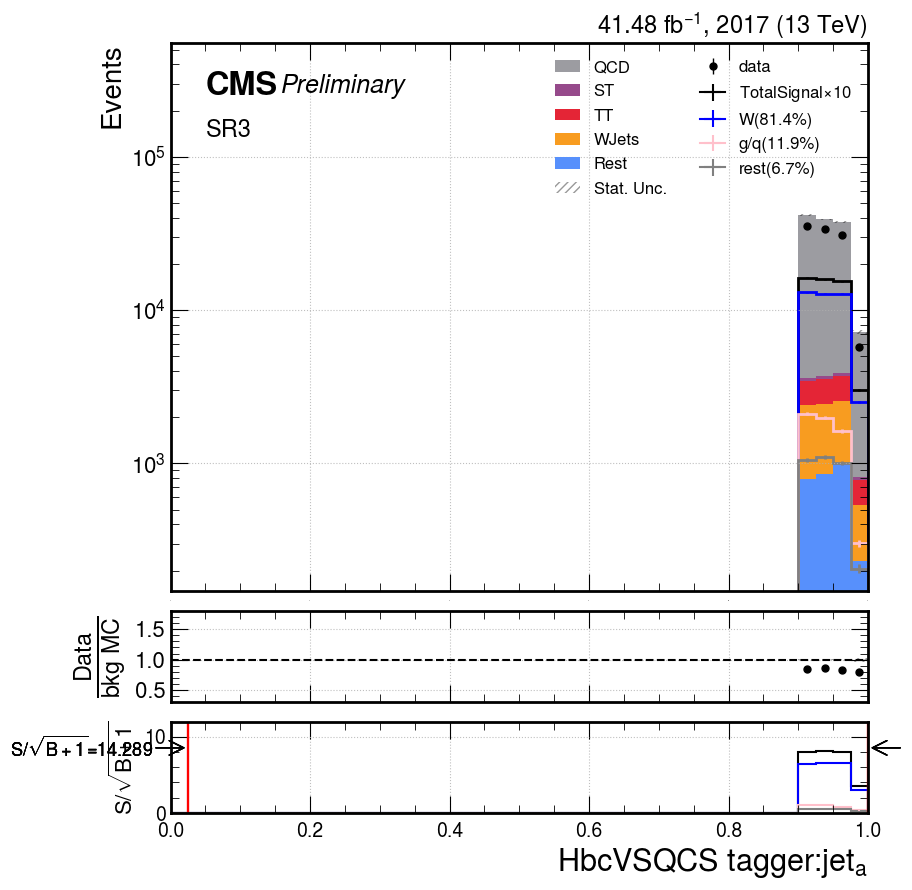

[4115742.93072707 5963472.17884304 5913241.04282462 5817690.27981612
 5776737.25330869 5683366.11847075 5467640.87893941 5041368.02190243
 4529201.41430662 3973020.5873477  3413880.44058643 2852483.0991273
 2337714.67061963 1875712.79784696 1479610.09429696 1149158.0325408
  873611.9495987   656674.53997406  492395.20136934  368053.03655597]
[[5534.86040022 6776.65737266 6826.9936601  6942.18082363 7059.49889713
  7076.24496852 6955.089936   6602.38135144 6135.37533438 5661.15425401
  5143.79503214 4584.24103775 4047.59838008 3542.70658627 3055.38426123
  2621.3054872  2202.92880229 1823.94235107 1500.9423986  1220.48192366]
 [5534.86040022 6776.65737266 6826.9936601  6942.18082363 7059.49889713
  7076.24496852 6955.089936   6602.38135144 6135.37533438 5661.15425401
  5143.79503214 4584.24103775 4047.59838008 3542.70658627 3055.38426123
  2621.3054872  2202.92880229 1823.94235107 1500.9423986  1220.48192366]]
Should scale signal *  123.25505405546205
0.5219003356768595
[[0.00149497 0.0

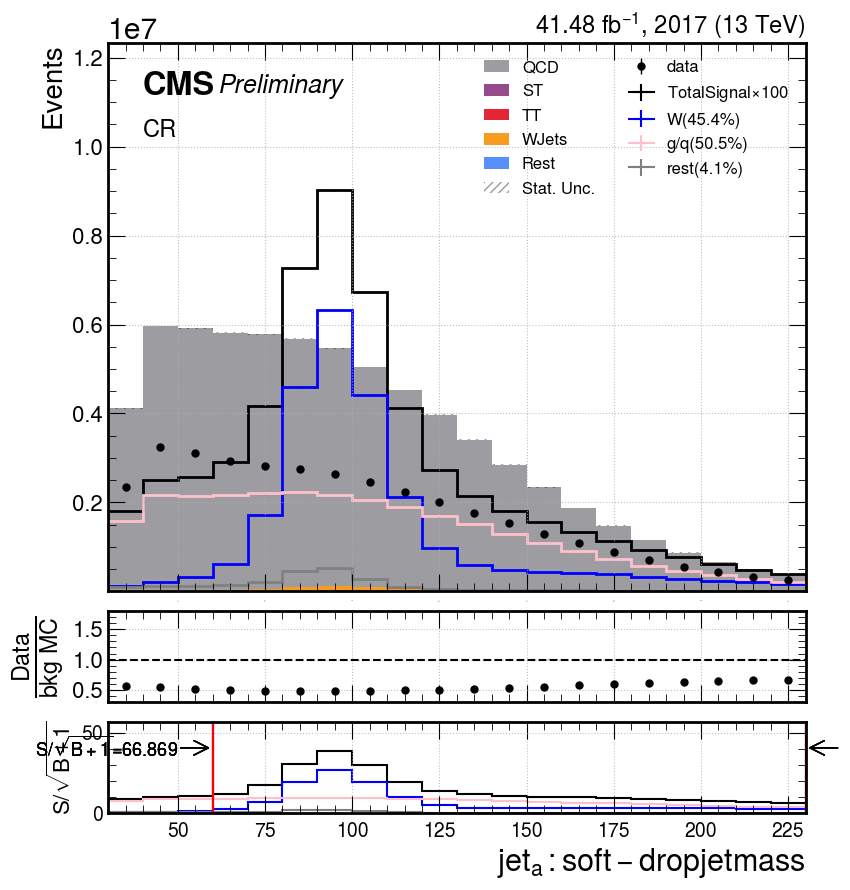

/tmp/ipykernel_703260/314159992.py:34: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_703260/314159992.py:51: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_703260/314159992.py:52: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/tmp/ipykernel_703260/1466309391.py:108: RuntimeWarning: invalid value encountered in divide
  ratio_error = np.sqrt(np.power(err/h,2) + np.power(bkg_err/bkg_h,2))
/tmp/ipykernel_703260/1466309391.py:112: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=ratio_uncertainty(h,bkg_h,"poisson"), color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_703260/1466309391.py:127: RuntimeWarning: invalid value encountered in divide
  ax1.stairs(values = 1 + bkg_err[0]/bkg_h, baseline = 1 - bkg_err[1]/bkg_h, edges = hist.axes[0].edges, **errps)
/tmp/ipykernel_703260/314

[5.61080129e+07 4.16051765e+06 1.94820441e+06 1.19580333e+06
 8.32836076e+05 6.18710964e+05 4.84433239e+05 3.90146531e+05
 3.29175565e+05 2.78190419e+05 2.39157746e+05 2.10899066e+05
 1.89175897e+05 1.64743189e+05 1.49061174e+05 1.37165972e+05
 1.23910237e+05 1.13974103e+05 1.05464523e+05 9.52571182e+04
 9.01157894e+04 8.55081950e+04 8.02178432e+04 7.29533309e+04
 7.06479248e+04 6.70572347e+04 6.20901790e+04 5.86211182e+04
 5.70461715e+04 5.48820154e+04 5.18572803e+04 5.02945539e+04
 4.84981662e+04 4.64350405e+04 4.46519229e+04 4.20042303e+04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[[20976.39226722  5693.56725926  3902.40095819  3064.42318431
   2558.59112914  2185.87677125  1932.8703755   1731.1352482
   1602.21235948  1474.51002028  1363.92461358  1282.66009552
   1217.09575172  1132.09590472  1082.56818522  1042.20871011
    985.10871907   938.51237647   915.86337418   858.30067888
    838.58825221   814.71022347   797.4899497    746.55712098
    744.5467217   

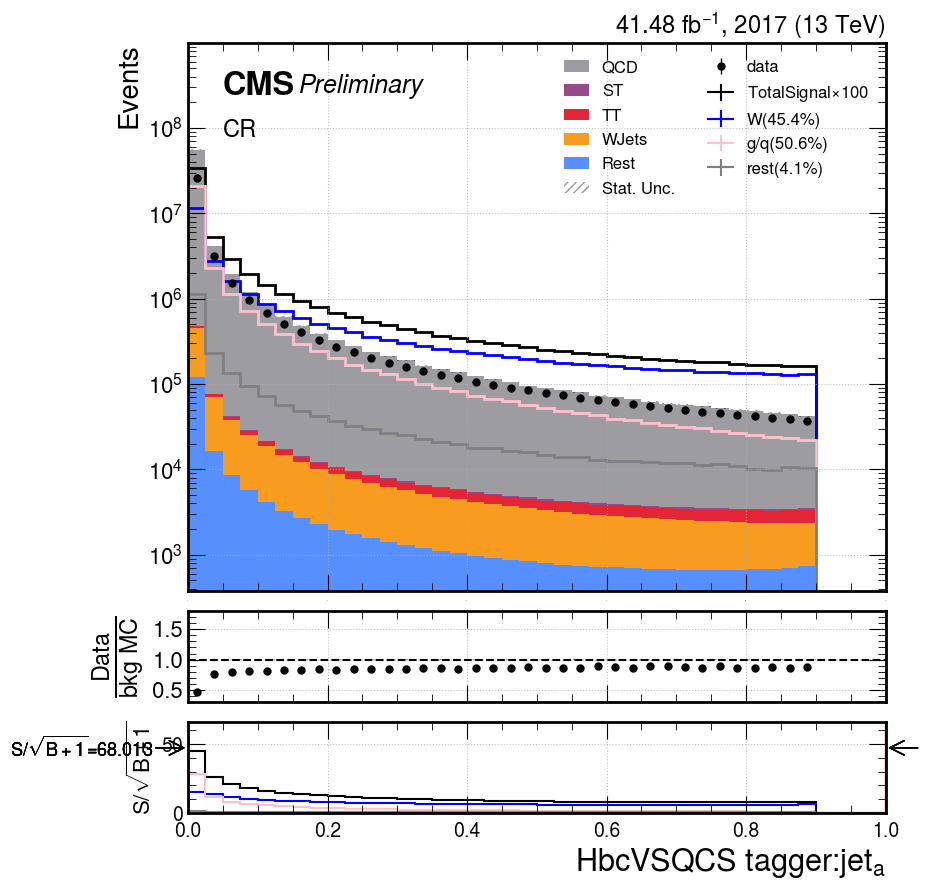

In [54]:
run_makeplots(region = "PS",  blind = False,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR1", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR2", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "SR3", blind = True,  othertext = "", deco = True) #this set to deco to True
run_makeplots(region = "CR",  blind = False,  othertext = "", deco = True) #this set to deco to True